In [59]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

# Retrieve connection details from environment variables
server = os.getenv("AZURE_SQL_SERVER")
database = os.getenv("AZURE_SQL_DATABASE")
username = os.getenv("AZURE_SQL_USER")
password = os.getenv("AZURE_SQL_PASSWORD")

# Define the connection string using SQLAlchemy format
conn_str = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# Create an SQLAlchemy engine
engine = create_engine(conn_str)

# Query the database
query = """
   WITH LatestRun AS (
    SELECT dateId, MAX(runId) AS maxRunId
    FROM CourtBookingLog
    GROUP BY dateId
)
SELECT DISTINCT cl.runId, cl.courtNumber, cl.dateId, cl.timeId, cl.p1, cl.p2, cl.p3, cl.p4, cl.courtType 
FROM CourtBookingLog AS cl
JOIN LatestRun AS lr
ON cl.dateId = lr.dateId AND cl.runId = lr.maxRunId
ORDER BY cl.dateId DESC, cl.timeId ASC;

    
"""
# Read data into a DataFrame
df = pd.read_sql(query, engine)

# Close the engine connection
engine.dispose()


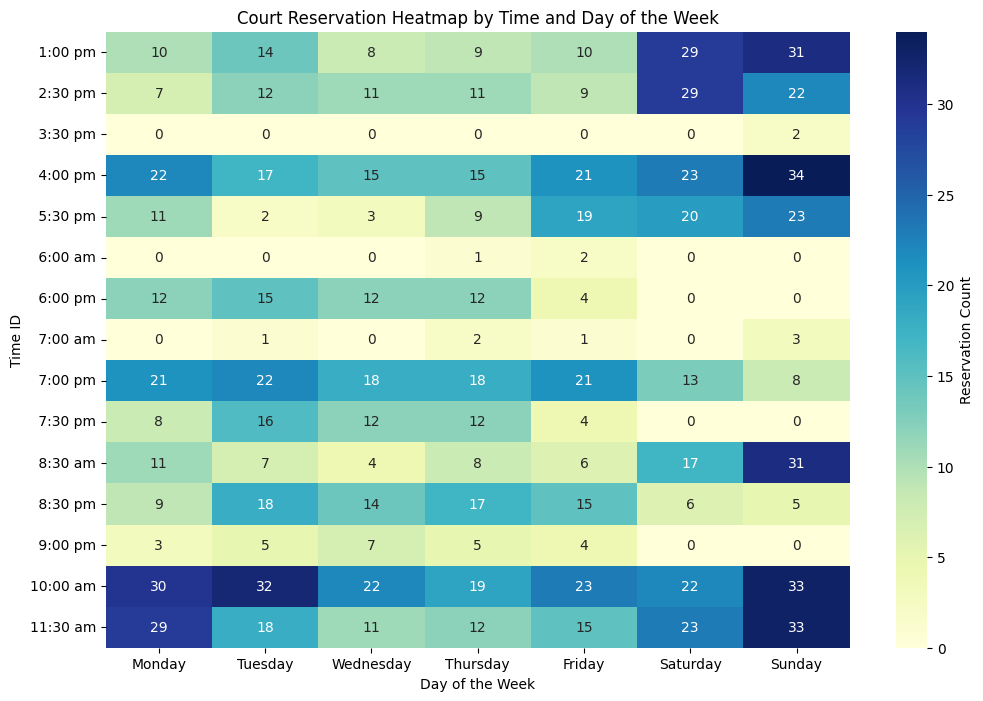

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert dateId to datetime format and extract day of the week
df['dateId'] = pd.to_datetime(df['dateId'], format='%d/%m/%Y')
df['dayOfWeek'] = df['dateId'].dt.day_name()

# Filter for final runs with courtType as "reserved"
final_run_df = df[df['courtType'] == 'Reserved']

# Sort by runId to get the final run for each dateId, courtNumber, and timeId combination
final_run_df = final_run_df.sort_values(by='runId').drop_duplicates(subset=['dateId', 'courtNumber', 'timeId'], keep='last')

# Count occurrences of each timeId by day of the week
popular_times = final_run_df.groupby(['dayOfWeek', 'timeId']).size().reset_index(name='count')

# Pivot data to create a table with timeId as rows and dayOfWeek as columns
heatmap_data = popular_times.pivot(index='timeId', columns='dayOfWeek', values='count').fillna(0)

# Reindex the columns to ensure all days of the week are included
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(columns=day_order, fill_value=0)

# Check if heatmap_data is empty
if heatmap_data.empty:
    print("No data available for court reservations.")
else:
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Reservation Count'})
    plt.title("Court Reservation Heatmap by Time and Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Time ID")
    plt.show()


In [73]:
import pandas as pd
from datetime import datetime
import re

# Query the database
query = """
   WITH LatestRun AS (
    SELECT dateId, MAX(runId) AS maxRunId
    FROM CourtBookingLog
    GROUP BY dateId
)
SELECT DISTINCT cl.runId, cl.courtNumber, cl.dateId, cl.timeId, cl.p1, cl.p2, cl.p3, cl.p4, cl.courtType 
FROM CourtBookingLog AS cl
JOIN LatestRun AS lr
ON cl.dateId = lr.dateId AND cl.runId = lr.maxRunId
ORDER BY cl.dateId DESC, cl.timeId ASC;

    
"""
# Read data into a DataFrame
df = pd.read_sql(query, engine)

# Convert `dateId` to datetime format
df['dateId'] = pd.to_datetime(df['dateId'], format='%d/%m/%Y')

# Remove "PT" from `timeId` and trim whitespace
df['timeId'] = df['timeId'].str.replace("PT", "").str.strip()

# Convert `timeId` to datetime time format
df['timeId'] = pd.to_datetime(df['timeId'], format='%I:%M %p', errors='coerce').dt.time

# Filter out any rows where `timeId` could not be parsed correctly
df = df[df['timeId'].notna()]

# Get current date and time
current_date = datetime.now().date()
current_time = datetime.now().time()

# Step 5: Filter for future dates or today's dates with times later than the current time
filtered_df = df[(df['dateId'].dt.date > current_date) | 
                 ((df['dateId'].dt.date == current_date) & (df['timeId'] > current_time))]

# Step 6: Filter for available courts only (`courtType` is NULL or "Available")
available_df = filtered_df[(filtered_df['courtType'].isna()) | (filtered_df['courtType'].str.lower() == 'available')]

# Step 7: Sort by `dateId` and `timeId` to find the next available slot
available_df = available_df.sort_values(by=['dateId', 'timeId'])

# Step 8: Retrieve the first available court
# next_available_court = available_df.head(1)

# Step 9: Display the next available court

available_df = available_df[available_df['courtNumber'] < 12]
if not available_df.empty:
    print("Next available court:")
    print(available_df[['dateId', 'timeId', 'courtNumber']])
else:
    print("No available courts found.")


Next available court:
         dateId    timeId  courtNumber
3680 2024-11-06  20:30:00          3.0
3685 2024-11-06  20:30:00          4.0
3690 2024-11-06  20:30:00          2.0
3695 2024-11-06  21:00:00          9.0
3697 2024-11-06  21:00:00         10.0
...         ...       ...          ...
2516 2024-11-12  20:30:00          4.0
2518 2024-11-12  20:30:00          3.0
2525 2024-11-12  21:00:00          9.0
2526 2024-11-12  21:00:00         10.0
2527 2024-11-12  21:00:00         11.0

[222 rows x 3 columns]


In [79]:
import pandas as pd

# Define your hitting list of partial names
hitting_list = ["Arham", "Joseph", "Areeb", "Owin", "Adin Con"]  # Replace with actual partial names

# Create a regex pattern that matches any name in the hitting list
pattern = '|'.join(hitting_list)  # Creates a pattern like 'PlayerA|PlayerB|PlayerC'

# Filter for reserved courts
# reserved_df = df[df['courtType'].notna() & (df['courtType'].str.lower() == 'Reserved')]
reserved_df = df[(df['dateId'].dt.date > current_date) | 
                 ((df['dateId'].dt.date == current_date) & (df['timeId'] > current_time))]


# Filter for players with partial name match in the hitting list
hitting_players_df = reserved_df[
    reserved_df['p1'].str.contains(pattern, case=False, na=False) |
    reserved_df['p2'].str.contains(pattern, case=False, na=False) |
    reserved_df['p3'].str.contains(pattern, case=False, na=False) |
    reserved_df['p4'].str.contains(pattern, case=False, na=False)
]


# Display the records of players who reserved courts and partially match the hitting list
print("Players who have reserved the court and partially match the hitting list:")
print(hitting_players_df[['dateId', 'timeId', 'courtNumber', 'p1', 'p2', 'p3', 'p4', 'courtType']])


Players who have reserved the court and partially match the hitting list:
         dateId    timeId  courtNumber               p1               p2  \
3364 2024-11-07  14:30:00          3.0   Isaiah Leong     Arham  Mefta     

        p3    p4 courtType  
3364  None  None   Walk On  
